In [114]:
# Loading the libraries to use for the analysis 
import pandas as pd 
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from nltk import pos_tag, ne_chunk
from nltk.tokenize import sent_tokenize, word_tokenize



In [98]:
# Loading the scrapped data and checking the top 5 entries
df = pd.read_csv('BA_reviews.csv')

df.head(10)

,Unnamed: 0,reviews
0,0,"✅ Trip Verified | Filthy plane, cabin staff o..."
1,1,✅ Trip Verified | Chaos at Terminal 5 with B...
2,2,Not Verified | BA cancelled our flight and co...
3,3,✅ Trip Verified | When on our way to Heathrow ...
4,4,"✅ Trip Verified | Nice flight, good crew, very..."
5,5,✅ Trip Verified | 8 months have passed and st...
6,6,✅ Trip Verified | In June my flight was cance...
7,7,✅ Trip Verified | Ground and cabin crew alway...
8,8,✅ Trip Verified | My family flew from Washing...
9,9,✅ Trip Verified | Easy check in a T5. Galleri...


## Data cleaning 

1. **Removing the verification status**: I took out the verification status from the reviews since I don't need it for my analysis. It's not relevant to what I'm looking into.

2. **Replacing short form words**: I changed words like "don't" to "do not." This is important because later on, I'm going to remove punctuation, and I want to make sure these words still make sense.

3. **Removing punctuation**: I got rid of all the punctuation marks in the text. This helps to simplify the data and focus on the words themselves.

4. **Case normalization**: I made all the words lowercase. This way, words like "Hello" and "hello" are treated the same, and it's easier to compare them.

5. **Removing Unicode characters**: I took out any special characters that might not be easily readable or necessary for my analysis. This ensures that I'm working with clean and understandable text.

6. **Removing stop words**: I got rid of common words like "the," "and," "is," etc. These words don't usually add much meaning to the analysis, so removing them helps me focus on the more important words.

7. **Lemmatization**: I simplified words to their base form. For example, "running" and "ran" would both become "run." This makes it easier to group together different forms of the same word.

By doing these steps, I made sure that the text I'm working with is consistent, easy to analyze, and focused on the actual content rather than unnecessary details.

In [110]:
# Removing text and symbols that are not necessary for the analysis eg. ✅ Trip Verified | 

# Also removing the words British airways and it's abbreviation ba as it is repeated in the dataset but it does not necessary add value to our analysis
# List of words/phrases to remove
words_to_remove = ['✅ Trip Verified | ', '✅ Verified Review | ', 'Not Verified | ', '❎ Not Verified | ', '❎ Unverified | ', '✅ Trip Verified |', 'British Airways', 'british airways', 'ba', 'b a']

# Remove specified words/phrases from the 'reviews' column
for word in words_to_remove:
    df['reviews'] = df['reviews'].str.replace(word, '')


# Checking to confirm the changes have worked
df.head(5)


,Unnamed: 0,reviews
0,0,filthy plane cabin staff ok appalling customer...
1,1,chaos terminal 5 cancellation delay staff giv...
2,2,cancelled flight could book u onto flight nex...
3,3,way heathrow airport merely 2 half hour schedu...
4,4,nice flight good crew good seat food would exp...


In [100]:
# Replacing most short form words with the full version of the words eg. don't becomes do not.
# Creating a contraction dictionary

contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# replace the contractions with their full forms
df["reviews"] = df["reviews"].replace(contractions, regex=True)

In [101]:
# Creating a function to loop through the review and remove punctuations 
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

#Removing punctions 
df["reviews"] = df["reviews"].apply(remove_punctuations)

In [102]:
# Normalize text to lowercase
df['reviews'] = df['reviews'].str.lower()


In [103]:
# Remove Unicode characters using a regular expression
df['reviews'] = df['reviews'].apply(lambda text: re.sub(r'[^\x00-\x7F]+', '', text))


In [112]:
# Removing stop words
# Download the NLTK stopwords and punkt 
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a text
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the 'reviews' column
df['reviews'] = df['reviews'].apply(remove_stopwords)




[nltk_data] Downloading package stopwords to C:\Users\Mr
[nltk_data]     Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Mr
[nltk_data]     Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
# Download NLTK resources 
nltk.download('wordnet')

# Instantiate the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization function
def lemmatize_text(text):
    words = word_tokenize(text)
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lem_words)

# Apply lemmatization to the 'reviews' column
df['reviews'] = df['reviews'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to C:\Users\Mr
[nltk_data]     Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Analysis
 1. **Topic Modeling**: I performed topic modeling to identify and categorize the main themes or topics present in the text data. By doing this, I can gain a better understanding of the different subjects being discussed in the reviews or documents without having to read each one individually. This helps me discover patterns, trends, and prevalent subjects that people are talking about.

2. **Sentiment Analysis**: I conducted sentiment analysis to determine the overall emotional tone or attitude expressed in the text. This allows me to quantify whether the reviews or comments are positive, negative, or neutral. By knowing the sentiment, I can quickly grasp the general public's opinion and assess how people feel about the subject of the reviews.

3. **Word Clouds**: I created word clouds as visual representations of the most common words in the text data. The more frequently a word appears in the text, the larger it appears in the word cloud. Word clouds are useful for getting a quick snapshot of the most prominent words associated with the content. They help in identifying keywords and visually showcasing the most frequently mentioned terms, which can be valuable for understanding the main focus of the text at a glance.

In [132]:
# Using Latent Dirichlet Allocation (LDA) to perfom topic modelling

# creating a copy of the cleaned dataset to be used for the analysis
df1 = df.copy()

#  Preprocessing the text data
def preprocess(text):
    return gensim.utils.simple_preprocess(text, deacc=True)  # deacc=True removes punctuations

df1['processed_reviews'] = df1['reviews'].apply(preprocess)

# Creating a dictionary and corpus for the topic model
dictionary = corpora.Dictionary(df1['processed_reviews'])
corpus = [dictionary.doc2bow(text) for text in df1['processed_reviews']]

# Training the LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=5,  # trying 5 topics
                                       passes=10,     # Number of iterations
                                       workers=2)

# Printing the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Assign topics to documents
df1['topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]



(0, '0.023*"seat" + 0.017*"flight" + 0.015*"class" + 0.011*"food" + 0.011*"business"')
(1, '0.023*"flight" + 0.014*"seat" + 0.011*"service" + 0.009*"time" + 0.008*"cabin"')
(2, '0.025*"flight" + 0.012*"london" + 0.011*"service" + 0.010*"staff" + 0.009*"food"')
(3, '0.033*"flight" + 0.011*"hour" + 0.009*"london" + 0.009*"airline" + 0.009*"customer"')
(4, '0.029*"flight" + 0.014*"seat" + 0.013*"service" + 0.012*"crew" + 0.009*"food"')


In [133]:
# Visualize the topics
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

[nltk_data] Downloading package vader_lexicon to C:\Users\Mr
[nltk_data]     Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


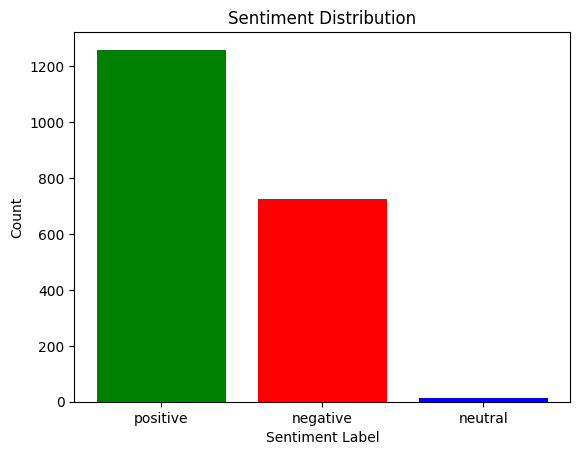

In [108]:
# Sentiment Analysis
# creating a copy of the cleaned dataset to be used for the analysis
df2 = df.copy()


# Downloading NLTK resource
nltk.download('vader_lexicon')

# Instantiate the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment labels
def get_sentiment_label(text):
    sentiment_scores = sia.polarity_scores(text)
    sentiment_label = 'positive' if sentiment_scores['compound'] > 0 else 'negative' if sentiment_scores['compound'] < 0 else 'neutral'
    return sentiment_label

# Apply sentiment analysis to the 'reviews' column and create a new column 'sentiment_label'
df2['sentiment_label'] = df2['reviews'].apply(get_sentiment_label)

# Count the occurrences of each sentiment label
sentiment_counts = df2['sentiment_label'].value_counts()

# Create a bar plot
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

C:\Users\Mr Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


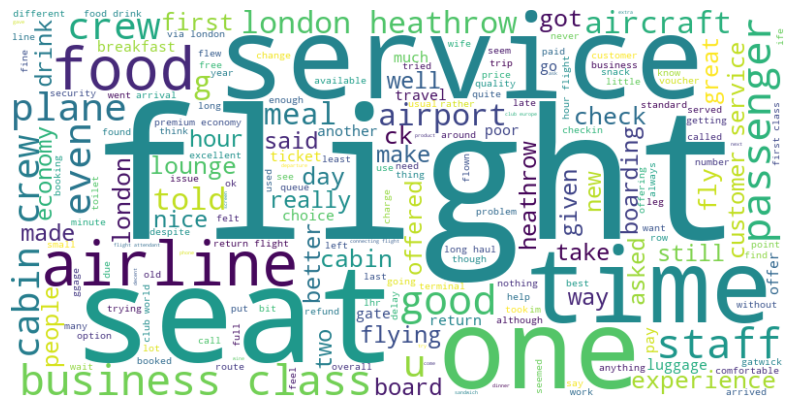

In [111]:
# Creating  a word cloud

# creating a copy of the cleaned dataset to be used for the analysis
df3 = df.copy()

# Generate the word cloud
all_reviews = ' '.join(df3['reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()